# 测试一下损失函数中加入积分能不能行

In [ ]:
import jax
import jax.numpy as jnp
from jax import config, grad, jit, vmap
from pyswarm import pso
from jax.scipy.optimize import minimize
config.update("jax_enable_x64", True)

MAX_NPARAMS = 10
initial_params = jnp.ones(MAX_NPARAMS, dtype=jnp.float64)

def evaluate(data: dict, params=initial_params) -> dict:
    inputs, outputs = data['inputs'], data['outputs']
    n_dim = inputs.shape[1] // 2
    q, q_t = inputs[:, :n_dim], inputs[:, n_dim:]
    true_accelerations = outputs

    @jit
    def compute_acceleration(q, q_t, params):
        def lag(q, q_t, params):
            return equation(q, q_t, params)
        hessian_q_t = jax.hessian(lag, 1)(q, q_t, params)
        grad_q = jax.grad(lag, 0)(q, q_t, params)
        jacobian_q_q_t = jax.jacobian(jax.grad(lag, 1), 0)(q, q_t, params)
        return jnp.linalg.pinv(hessian_q_t) @ (grad_q - jacobian_q_q_t @ q_t)

    batch_compute_acceleration = jit(vmap(compute_acceleration, (0, 0, None)))

    @jit
    def loss_fn(params):
        pred = batch_compute_acceleration(q, q_t, params)
        return jnp.mean(jnp.square(pred - true_accelerations))

    def run_optimization(objective_fn, initial_guess):
        if initial_guess.size > MAX_NPARAMS:
            result = minimize(objective_fn, initial_guess,
                            method='BFGS', options={'maxiter': 500})
            return result.x
        else:
            def pso_wrapper(x):
                return objective_fn(jnp.array(x))
            
            lb = [-1.0]*initial_guess.size
            ub = [10.0]*initial_guess.size
            
            pso_params, _ = pso(pso_wrapper, lb, ub, 
                            swarmsize=30, maxiter=200)
            
            result = minimize(objective_fn, jnp.array(pso_params),
                            method='BFGS', options={'maxiter': 500})
            return result.x


    # 敏感度分析模块
    def calculate_sensitivities(opt_params, base_loss):
        mask = 1 - jnp.eye(MAX_NPARAMS)
        
        @jit
        def batch_loss(params_matrix):
            return vmap(loss_fn)(params_matrix * mask)

        def sensitivity_objective(flat_params):
            matrix_params = flat_params.reshape(MAX_NPARAMS, MAX_NPARAMS)
            return jnp.sum(batch_loss(matrix_params))

        try:
            initial_flat = (opt_params * mask).flatten()
            optimized_flat = run_optimization(sensitivity_objective, initial_flat)
            optimized_matrix = optimized_flat.reshape(MAX_NPARAMS, MAX_NPARAMS)
            losses = batch_loss(optimized_matrix)
            relative_loss = (losses - base_loss) / base_loss
            return {i: float(jnp.nan_to_num(relative_loss[i])) for i in range(MAX_NPARAMS)}
            
        except Exception as e:
            print(f"Sensitivity analysis error: {str(e)}")
            return {i: 0.0 for i in range(MAX_NPARAMS)}


    # 主流程
    try:
        optimized_params = run_optimization(loss_fn, params)
        final_loss = loss_fn(optimized_params)
    except Exception as e:
        print(f"Optimization failed: {e}")
        return None

    if not jnp.isfinite(final_loss):
        return None

    return {
        'params': optimized_params,
        'loss': final_loss,
        'sensitivities': calculate_sensitivities(optimized_params, final_loss)
    }

@jit
def equation(q: jnp.array, q_t: jnp.array, params: jnp.array) -> jnp.array:
    q1, q2 = q[...,0], q[...,1]
    q1_t, q2_t = q_t[...,0], q_t[...,1]
    
    T = params[0]*(q1_t**2 + q2_t**2) 
    V = - params[1]/jnp.sqrt(q1**2 + q2**2)

    return T - V


In [ ]:
from jax import random

import pandas as pd
# 读取 CSV 文件并转换为 NumPy 数组
data0 = pd.read_csv('./xy_orbit.csv')#
tae = data0.to_numpy()

# 使用 JAX 的数组操作替换 PyTorch 的操作
t = jnp.array(tae[:, 0], dtype=jnp.float64)  # 转换为 JAX 数组
state = jnp.array(tae[:, 1:], dtype=jnp.float64)  # 转换为 JAX 数组
print(state)
print(t)
# 将数据存储在字典中
data = {
    'times': t,
    'states': state
}



print(initial_params)
# 评估并优化参数
final_loss = evaluate(data, initial_params)
print("最终损失值 (MSE):", final_loss)

In [ ]:
import jax
import jax.numpy as jnp
from jax import config, grad, jit, vmap
from jax.experimental.ode import odeint
from pyswarm import pso
from jax.scipy.optimize import minimize
import traceback
config.update("jax_enable_x64", True)

# --- Global Constants ---
# Define MAX_NPARAMS, used in run_optimization logic
# Adjust this value based on your system's typical parameter count
# or the threshold where you want to switch optimization methods.
MAX_NPARAMS = 10
initial_params = jnp.ones(MAX_NPARAMS, dtype=jnp.float64)

def evaluate(data: dict, params: jnp.array) -> dict:
    times = data['times']
    target_states = data['states']
    initial_state = target_states[0]
    n_dim = target_states.shape[1] // 2

    def compute_acceleration(q, q_t, params_acc):
        def lag(q_lag, q_t_lag, params_lag):
            return equation(q_lag, q_t_lag, params_lag)
        try:
            hessian_q_t = jax.hessian(lag, 1)(q, q_t, params_acc)
            grad_q = jax.grad(lag, 0)(q, q_t, params_acc)
            jacobian_q_q_t = jax.jacobian(jax.grad(lag, 1), 0)(q, q_t, params_acc)
            inv_hessian = jnp.linalg.pinv(hessian_q_t, rtol=1e-10)
            accel = inv_hessian @ (grad_q - jacobian_q_q_t @ q_t)
        except jnp.linalg.LinAlgError:
            print(f"Warning: Singular matrix in acceleration computation.")
            accel = jnp.full_like(q, jnp.nan)
        return accel

    @jit
    def dynamics_func(y, t, params_dyn):
        q = y[:n_dim]
        q_t = y[n_dim:]
        q_tt = compute_acceleration(q, q_t, params_dyn)
        return jnp.concatenate([q_t, q_tt])

    @jit
    def loss_fn(params_loss):
        pred_states = odeint(dynamics_func, initial_state, times, params_loss, rtol=1e-6, atol=1e-6)
        loss = jnp.mean(jnp.square(pred_states - target_states))
        return loss

    def run_optimization(objective_fn, initial_guess):
        n_params_opt = initial_guess.size
        print(f"Running optimization for {n_params_opt} parameters.")

        if n_params_opt > MAX_NPARAMS:
            print("Using BFGS optimizer.")
            try:
                result = minimize(objective_fn, initial_guess, method='BFGS', options={'maxiter': 500})
                if not result.success: 
                    print(f"Warning: BFGS optimization did not converge. Status: {result.status}")
                return result.x
            except Exception as e:
                print(f"BFGS optimization failed: {e}")
                # 返回初始猜测值，避免完全失败
                return initial_guess
        else:
            print("Using PSO + BFGS optimizer.")
            def pso_wrapper(x):
                return float(objective_fn(jnp.array(x, dtype=initial_guess.dtype)))

            # 使用合理的搜索范围
            lb = jnp.full(n_params_opt, -1.0, dtype=initial_guess.dtype).tolist()
            ub = jnp.full(n_params_opt, 10.0, dtype=initial_guess.dtype).tolist()

            try:
                print("Starting PSO optimization...")
                pso_params, pso_loss = pso(pso_wrapper, lb, ub, swarmsize=50, maxiter=200, debug=True)
                pso_params = jnp.array(pso_params, dtype=initial_guess.dtype)
                print(f"PSO finished with loss: {pso_loss}. Refining with BFGS...")
                
                try:
                    result = minimize(objective_fn, pso_params, method='BFGS', options={'maxiter': 500})
                    if not result.success:
                        print(f"Warning: BFGS (post-PSO) did not converge. Status: {result.status}")
                    print(f"BFGS refinement complete. Final loss: {objective_fn(result.x)}")
                    return result.x
                except Exception as e:
                    print(f"BFGS refinement failed: {e}, returning PSO results.")
                    return pso_params
                
            except Exception as e:
                print(f"PSO optimization failed: {e}. Falling back to BFGS.")
                try:
                    result = minimize(objective_fn, initial_guess, method='BFGS', options={'maxiter': 500})
                    if not result.success:
                        print(f"Warning: Fallback BFGS optimization did not converge. Status: {result.status}")
                    return result.x
                except Exception as e:
                    print(f"Fallback BFGS also failed: {e}")
                    return initial_guess  # 返回初始猜测值，避免完全失败

    # --- Sensitivity Analysis (Corrected Logic) ---
    def calculate_sensitivities(opt_params, base_loss):
        n_params_sens = opt_params.size
        if n_params_sens == 0:
            print("Warning: Skipping sensitivity analysis. No parameters found.")
            return {}

        print(f"Calculating sensitivities for {n_params_sens} parameters (re-optimization method)...")

        # Use vmap for batch loss calculation
        @jit
        def batch_loss(params_matrix):
            # Define the single evaluation loss function again, taking params only
            def single_loss_eval(p):
                pred_states = odeint(dynamics_func, initial_state, times, p, rtol=1e-6, atol=1e-6)
                pred_states = jnp.nan_to_num(pred_states, nan=jnp.inf)
                return jnp.mean(jnp.square(pred_states - target_states))
            # Ensure vmap operates correctly on the parameters dimension
            return vmap(single_loss_eval)(params_matrix)

        try:
            # Create mask based on the actual number of optimized parameters
            mask = 1.0 - jnp.eye(n_params_sens, dtype=opt_params.dtype)
            # Create matrix where row 'i' has param 'i' = 0
            # Broadcast opt_params (shape [n]) with mask (shape [n, n])
            masked_params = jnp.expand_dims(opt_params, 0) * mask

            # Calculate loss for each zeroed case
            losses_if_zero = batch_loss(masked_params)

            # Calculate relative loss change, adding epsilon for numerical stability
            relative_loss_change = (losses_if_zero - base_loss) / (base_loss + 1e-15)

            # Build sensitivity dictionary using the actual number of parameters
            sensitivities = {i: float(jnp.nan_to_num(relative_loss_change[i])) for i in range(n_params_sens)}

            print("Sensitivities calculated based on zeroing each parameter.")
            return sensitivities

        except Exception as e:
            print(f"Sensitivity analysis error: {str(e)}")
            print(traceback.format_exc())
            # Return zero sensitivities for all actual parameters on error
            return {i: 0.0 for i in range(n_params_sens)}

    # --- Main Execution Flow ---
    print("Starting parameter evaluation...")
    try:
        # Ensure initial params have a float dtype for optimization
        initial_params_float = jnp.asarray(params, dtype=jnp.float64)
        optimized_params = run_optimization(loss_fn, initial_params_float)
        print(f"Optimization finished. Optimal parameters: {optimized_params}")
        # Ensure optimized params are used with correct dtype for final loss calculation
        final_loss = loss_fn(jnp.asarray(optimized_params, dtype=jnp.float64))
        print(f"Final loss: {final_loss}")

    except Exception as e:
        print(f"Optimization failed: {e}")
        print(traceback.format_exc())
        return None # Indicate failure

    # Check if optimization produced valid results before sensitivity analysis
    if optimized_params is None or not jnp.isfinite(final_loss) or final_loss == jnp.inf:
        print(f"Optimization resulted in invalid parameters or non-finite loss: {final_loss}. Skipping sensitivity analysis.")
        # Return results without sensitivities if optimization failed or loss is invalid
        return {
            'params': optimized_params, # Could be None
            'loss': float(final_loss) if jnp.isfinite(final_loss) else float('inf'),
            'sensitivities': {} # Return empty sensitivities
        }

    # Proceed with sensitivity analysis only if optimization was successful
    sensitivities = calculate_sensitivities(optimized_params, final_loss)

    return {
        'params': optimized_params,
        'loss': float(final_loss), # Convert scalar JAX array to float
        'sensitivities': sensitivities
    }

# Dummy equation function if not provided elsewhere
@jit
def equation(q: jnp.array, q_t: jnp.array, params: jnp.array) -> jnp.array:

    q1, q2 = q[..., 0], q[..., 1]
    q1_t, q2_t = q_t[..., 0], q_t[..., 1]

    T = 0.5 * params[0] * (q1_t**2 + q2_t**2) # Corrected Kinetic Energy form (factor of 0.5)
    V = - params[1] / jnp.sqrt(q1**2 + q2**2 + 1e-8) # Potential Energy (add epsilon for stability near origin)

    return T - V



In [ ]:
from jax import random
import jax.numpy as jnp
import pandas as pd

data0 = pd.read_csv('./xy_orbit.csv') # 
tae = data0.to_numpy()

# 使用 JAX 的数组操作
t = jnp.array(tae[:, 0], dtype=jnp.float64)/100
state = jnp.array(tae[:, 1:], dtype=jnp.float64)/1e10 # 

data = {
    'times': t,
    'states': state # Use the scaled states
}

initial_params = jnp.array([1.0] * 10, dtype=jnp.float64) 

print("Initial Parameters (for scaled system):", initial_params)

results = evaluate(data, initial_params) # Pass scaled data and initial guess

# --- Output Results ---
print("\n--- Evaluation Results ---")
if results:
    print(f"Optimized Parameters (for scaled system): {results['params']}")
    print(f"Final Loss (MSE, scaled units): {results['loss']}")
    print(f"Sensitivities (scaled units): {results['sensitivities']}")

# 问题很大，我们首先来验证一下计算是否可行。
我们首先验证计算的加速度是否正确。

In [2]:
# 设置一个数据初始数据
from jax import random
import jax
import jax.numpy as jnp
import pandas as pd

#初始状态
initial = jnp.array([1.0, 2.0 , 3.0, 4.0])

#对应加速度
def dynamic(state,t):
    x = state[0]
    y = state[1]
    x_tt = -x/(x**2 + y**2)**(3/2)
    y_tt = -y/(x**2 + y**2)**(3/2)
    return jnp.array([state[2],state[3],x_tt, y_tt])

acceleration = dynamic(initial,t)

print("Initial State:", initial)
print("Acceleration:", acceleration)

#对应的方程
def equation(q: jnp.array, q_t: jnp.array, params: jnp.array) -> jnp.array:

    q1, q2 = q[..., 0], q[..., 1]
    q1_t, q2_t = q_t[..., 0], q_t[..., 1]

    T = params[0] *(q1_t**2 + q2_t**2) # Corrected Kinetic Energy form (factor of 0.5)
    V = - params[1] / jnp.sqrt(q1**2 + q2**2) # Potential Energy (add epsilon for stability near origin)

    return T - V

def compute_acceleration(state,t, params):
    q = state[:2]
    q_t = state[2:]
    def lag(q, q_t, params):
        return equation(q, q_t, params)
    hessian_q_t = jax.hessian(lag, 1)(q, q_t, params)
    grad_q = jax.grad(lag, 0)(q, q_t, params)
    jacobian_q_q_t = jax.jacobian(jax.grad(lag, 1), 0)(q, q_t, params)
    q_tt = jnp.linalg.pinv(hessian_q_t) @ (grad_q - jacobian_q_q_t @ q_t)
    return jnp.concatenate([q_t, q_tt])

params = jnp.array([0.5, 1.0])

print('acc',compute_acceleration(initial,t, params))



Initial State: [1. 2. 3. 4.]
Acceleration: [ 3.          4.         -0.08944272 -0.17888544]
acc [ 3.          4.         -0.08944272 -0.17888544]


# 检验完毕，能够正确计算加速度。
接着我们开始积分，看看其能否使用自动加速度计算的式子积分

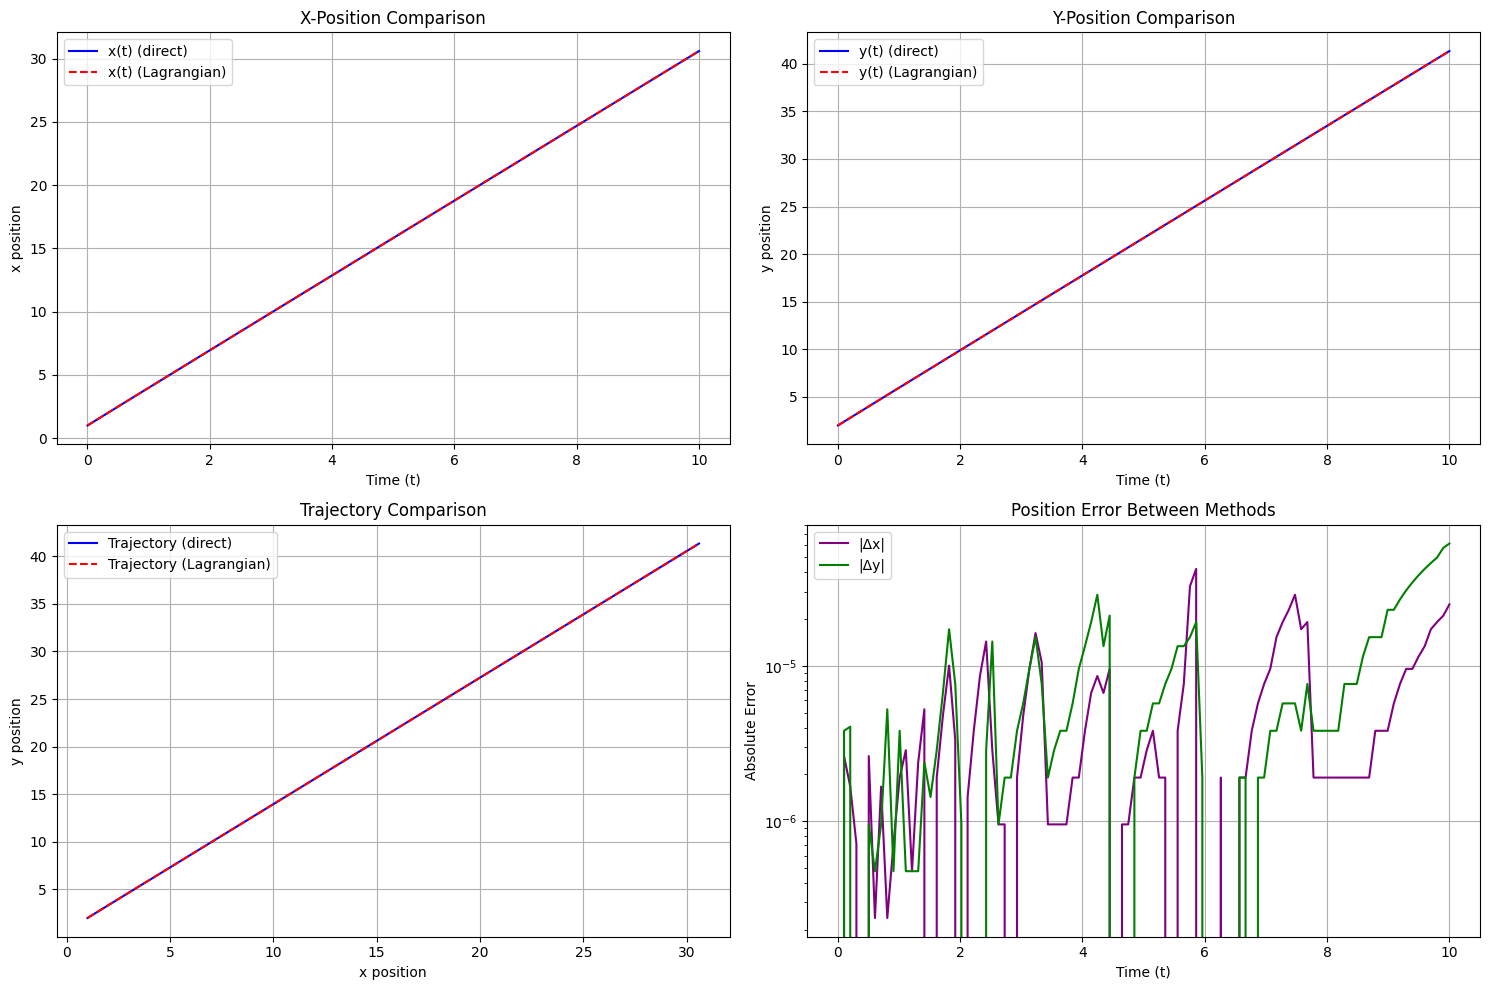

In [ ]:
import jax.numpy as jnp
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

t = jnp.linspace(0, 10, 1000)  # 时间点，从 0 到 10，共 100 个点
y0 = initial

# 使用 odeint 求解
y1 = odeint(dynamic, y0, t)

def wrapped_acceleration(state, t):
    return compute_acceleration(state, t, params)

y2 = odeint(wrapped_acceleration, y0,t)

# 可视化 - 比较相同的变量
plt.figure(figsize=(15, 10))

# 比较 x 坐标
plt.subplot(2, 2, 1)
plt.plot(t, y1[:, 0], label='x(t) (direct)', color='blue')
plt.plot(t, y2[:, 0], label='x(t) (Lagrangian)', color='red', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('x position')
plt.title('X-Position Comparison')
plt.legend()
plt.grid(True)

# 比较 y 坐标
plt.subplot(2, 2, 2)
plt.plot(t, y1[:, 1], label='y(t) (direct)', color='blue')
plt.plot(t, y2[:, 1], label='y(t) (Lagrangian)', color='red', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('y position')
plt.title('Y-Position Comparison')
plt.legend()
plt.grid(True)

# 轨迹图 (x-y 平面)
plt.subplot(2, 2, 3)
plt.plot(y1[:, 0], y1[:, 1], label='Trajectory (direct)', color='blue')
plt.plot(y2[:, 0], y2[:, 1], label='Trajectory (Lagrangian)', color='red', linestyle='--')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Trajectory Comparison')
plt.legend()
plt.grid(True)

# 计算误差
error_x = jnp.abs(y1[:, 0] - y2[:, 0])
error_y = jnp.abs(y1[:, 1] - y2[:, 1])
plt.subplot(2, 2, 4)
plt.plot(t, error_x, label='|Δx|', color='purple')
plt.plot(t, error_y, label='|Δy|', color='green')
plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title('Position Error Between Methods')
plt.legend()
plt.yscale('log')  # 对数刻度更容易看出误差增长趋势
plt.grid(True)

plt.tight_layout()
plt.show()



Initial State: [1.  0.  0.  0.9]
Acceleration (dynamic): [ 0.   0.9 -1.  -0. ]
Acceleration (Lagrangian): [ 0.   0.9 -1.   0. ]
Acceleration difference: [0. 0. 0. 0.]


C:\Users\19464\AppData\Local\Temp\ipykernel_21292\696145345.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


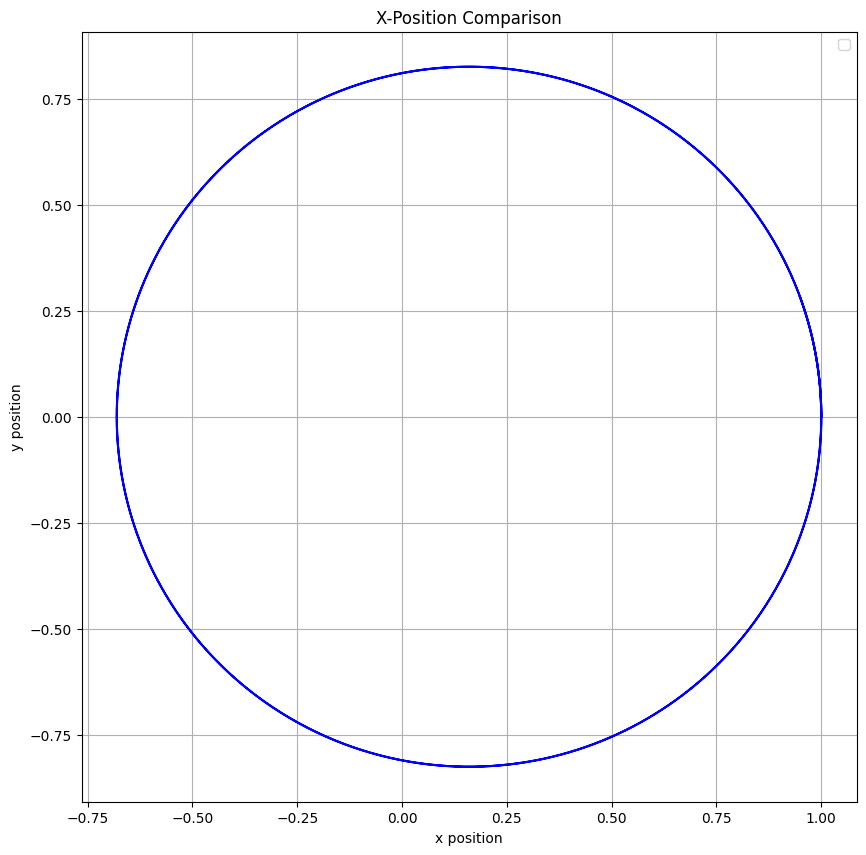

'# 计算并展示误差\nerror_x = jnp.abs(y1[:, 0] - y2[:, 0])\nerror_y = jnp.abs(y1[:, 1] - y2[:, 1])\nmax_error_x = jnp.max(error_x)\nmax_error_y = jnp.max(error_y)\nmean_error_x = jnp.mean(error_x)\nmean_error_y = jnp.mean(error_y)\n\nprint(f"Maximum Error in x: {max_error_x:.2e}")\nprint(f"Maximum Error in y: {max_error_y:.2e}")\nprint(f"Mean Error in x: {mean_error_x:.2e}")\nprint(f"Mean Error in y: {mean_error_y:.2e}")\n\n# 计算各时间点系统总能量\ndef total_energy(state, params):\n    q = state[:2]\n    q_t = state[2:]\n    T = params[0] * (q_t[0]**2 + q_t[1]**2)  # 动能\n    V = -params[1] / jnp.sqrt(q[0]**2 + q[1]**2)  # 势能\n    return T + V\n\n# 计算两种方法的能量\nenergy1 = jnp.array([total_energy(state, params) for state in y1])\nenergy2 = jnp.array([total_energy(state, params) for state in y2])\nenergy_error = jnp.abs(energy1 - energy2)\n\n# 可视化结果\nplt.figure(figsize=(15, 15))\n\n# 比较 x 坐标\nplt.subplot(3, 2, 1)\nplt.plot(t, y1[:, 0], label=\'x(t) (direct)\', color=\'blue\')\nplt.plot(t, y2[:, 0], label=\'x(

In [2]:
# 设置一个数据初始数据
from jax import random, config
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from jax.experimental.ode import odeint
from functools import partial

# 启用float64精度
config.update("jax_enable_x64", True)

# 初始状态 (使用float64)
initial = jnp.array([1.0, 0.0, 0.0, 0.9], dtype=jnp.float64)

# 对应加速度
def dynamic(state, t):
    x = state[0]
    y = state[1]
    x_tt = -x/(x**2 + y**2)**(3/2)
    y_tt = -y/(x**2 + y**2)**(3/2)
    return jnp.array([state[2], state[3], x_tt, y_tt], dtype=jnp.float64)

# 对应的方程
def equation(q: jnp.array, q_t: jnp.array, params: jnp.array) -> jnp.array:
    q1, q2 = q[..., 0], q[..., 1]
    q1_t, q2_t = q_t[..., 0], q_t[..., 1]

    T = params[0] * (q1_t**2 + q2_t**2)  # Kinetic Energy
    V = -params[1] / jnp.sqrt(q1**2 + q2**2)  # Potential Energy

    return T - V

def compute_acceleration(state, t, params):
    q = state[:2]
    q_t = state[2:]
    def lag(q, q_t, params):
        return equation(q, q_t, params)
    hessian_q_t = jax.hessian(lag, 1)(q, q_t, params)
    grad_q = jax.grad(lag, 0)(q, q_t, params)
    jacobian_q_q_t = jax.jacobian(jax.grad(lag, 1), 0)(q, q_t, params)
    q_tt = jnp.linalg.pinv(hessian_q_t) @ (grad_q - jacobian_q_q_t @ q_t)
    return jnp.concatenate([q_t, q_tt])

# 使用float64的参数
params = jnp.array([0.5, 1.0], dtype=jnp.float64)

# 打印初始状态下的加速度比较
print("Initial State:", initial)
acceleration1 = dynamic(initial, 0.0)
acceleration2 = compute_acceleration(initial, 0.0, params)
print("Acceleration (dynamic):", acceleration1)
print("Acceleration (Lagrangian):", acceleration2)
print("Acceleration difference:", jnp.abs(acceleration1 - acceleration2))

# 设置更精细的时间点
t = jnp.linspace(0, 10, 2000, dtype=jnp.float64)  # 增加到1000个点，使用float64

# 使用高精度ODE积分参数
def rk45_wrapper(func, y0, t, *args):
    """更精确的Runge-Kutta 4(5)积分器包装函数"""
    return odeint(
        func, 
        y0, 
        t, 
        *args,
        rtol=1e-12,         # 相对容差更低
        atol=1e-12,         # 绝对容差更低
        mxstep=1000        # 最大步数增加
    )

# 使用包装器求解ODE
y0 = initial
y1 = rk45_wrapper(dynamic, y0, t)

# 包装第二个函数以包含参数
def wrapped_acceleration(state, t):
    return compute_acceleration(state, t, params)

y2 = rk45_wrapper(wrapped_acceleration, y0, t)


data = pd.DataFrame({
    'time': t,
    'x_direct': y1[:, 0],
    'y_direct': y1[:, 1],
    'vx_direct': y1[:, 2],
    'vy_direct': y1[:, 3],
})

# 保存到CSV文件
data.to_csv('orbit.csv', index=False)

plt.figure(figsize=(10, 10))

plt.plot(y1[:, 0],y1[:, 1], color='blue')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('X-Position Comparison')
plt.legend()
plt.grid(True)
plt.show()
'''# 计算并展示误差
error_x = jnp.abs(y1[:, 0] - y2[:, 0])
error_y = jnp.abs(y1[:, 1] - y2[:, 1])
max_error_x = jnp.max(error_x)
max_error_y = jnp.max(error_y)
mean_error_x = jnp.mean(error_x)
mean_error_y = jnp.mean(error_y)

print(f"Maximum Error in x: {max_error_x:.2e}")
print(f"Maximum Error in y: {max_error_y:.2e}")
print(f"Mean Error in x: {mean_error_x:.2e}")
print(f"Mean Error in y: {mean_error_y:.2e}")

# 计算各时间点系统总能量
def total_energy(state, params):
    q = state[:2]
    q_t = state[2:]
    T = params[0] * (q_t[0]**2 + q_t[1]**2)  # 动能
    V = -params[1] / jnp.sqrt(q[0]**2 + q[1]**2)  # 势能
    return T + V

# 计算两种方法的能量
energy1 = jnp.array([total_energy(state, params) for state in y1])
energy2 = jnp.array([total_energy(state, params) for state in y2])
energy_error = jnp.abs(energy1 - energy2)

# 可视化结果
plt.figure(figsize=(15, 15))

# 比较 x 坐标
plt.subplot(3, 2, 1)
plt.plot(t, y1[:, 0], label='x(t) (direct)', color='blue')
plt.plot(t, y2[:, 0], label='x(t) (Lagrangian)', color='red', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('x position')
plt.title('X-Position Comparison')
plt.legend()
plt.grid(True)

# 比较 y 坐标
plt.subplot(3, 2, 2)
plt.plot(t, y1[:, 1], label='y(t) (direct)', color='blue')
plt.plot(t, y2[:, 1], label='y(t) (Lagrangian)', color='red', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('y position')
plt.title('Y-Position Comparison')
plt.legend()
plt.grid(True)

# 轨迹图 (x-y 平面)
plt.subplot(3, 2, 3)
plt.plot(y1[:, 0], y1[:, 1], label='Trajectory (direct)', color='blue')
plt.plot(y2[:, 0], y2[:, 1], label='Trajectory (Lagrangian)', color='red', linestyle='--')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Trajectory Comparison')
plt.legend()
plt.grid(True)

# 绝对误差
plt.subplot(3, 2, 4)
plt.plot(t, error_x, label='|Δx|', color='purple')
plt.plot(t, error_y, label='|Δy|', color='green')
plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title('Position Error Between Methods')
plt.legend()
plt.yscale('log')  # 对数刻度更容易看出误差增长趋势
plt.grid(True)

# 相对误差
plt.subplot(3, 2, 5)
# 避免除以零
mask_x = jnp.abs(y1[:, 0]) > 1e-10
mask_y = jnp.abs(y1[:, 1]) > 1e-10
rel_error_x = jnp.where(mask_x, jnp.abs((y1[:, 0] - y2[:, 0]) / y1[:, 0]), jnp.nan)
rel_error_y = jnp.where(mask_y, jnp.abs((y1[:, 1] - y2[:, 1]) / y1[:, 1]), jnp.nan)

plt.plot(t, rel_error_x, label='|Δx|/|x|', color='purple')
plt.plot(t, rel_error_y, label='|Δy|/|y|', color='green')
plt.xlabel('Time (t)')
plt.ylabel('Relative Error')
plt.title('Relative Position Error')
plt.legend()
plt.yscale('log')
plt.grid(True)

# 能量误差
plt.subplot(3, 2, 6)
plt.plot(t, energy1, label='Energy (direct)', color='blue')
plt.plot(t, energy2, label='Energy (Lagrangian)', color='red', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('Total Energy')
plt.title('Energy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 展示能量误差
plt.figure(figsize=(10, 5))
plt.plot(t, energy_error, label='|ΔE|', color='purple')
plt.xlabel('Time (t)')
plt.ylabel('Energy Error')
plt.title('Absolute Energy Error Between Methods')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()'''


# 验证完毕，可以有效积分，自行添加积分到损失函数中验证效果

In [5]:
import jax
import jax.numpy as jnp
from jax import config, grad, jit, vmap
from pyswarm import pso
from jax.experimental.ode import odeint
from jax.scipy.optimize import minimize
config.update("jax_enable_x64", True)

MAX_NPARAMS = 10
initial_params = jnp.ones(MAX_NPARAMS, dtype=jnp.float64)

def evaluate(data: dict, params=initial_params) -> dict:
    states, times= data['states'], data['times']
    n_dim = states.shape[1] // 2
    state0 = states[0]

    @jit
    def compute_acceleration(state, t, params):
        q, q_t = state[:n_dim], state[n_dim:]
        def lag(q, q_t, params):
            return equation(q, q_t, params)
        hessian_q_t = jax.hessian(lag, 1)(q, q_t, params)
        grad_q = jax.grad(lag, 0)(q, q_t, params)
        jacobian_q_q_t = jax.jacobian(jax.grad(lag, 1), 0)(q, q_t, params)
        q_tt = jnp.linalg.pinv(hessian_q_t) @ (grad_q - jacobian_q_q_t @ q_t)
        return jnp.concatenate([q_t, q_tt])

    @jit
    def loss_fn(params):
        def wrapped_acceleration(state, t):
            return compute_acceleration(state, t, params)
        pred = odeint(compute_acceleration, state0, times, params, rtol=1e-12, atol=1e-12, mxstep=1000)
        return jnp.mean(jnp.square(pred - states))

    def run_optimization(objective_fn, initial_guess):
        print(initial_guess.size,MAX_NPARAMS)
        if initial_guess.size > MAX_NPARAMS:
            result = minimize(objective_fn, initial_guess,
                            method='BFGS', options={'maxiter': 500})
            return result.x
        else:
            def pso_wrapper(x):
                return objective_fn(jnp.array(x))
            
            lb = [-10.0]*initial_guess.size
            ub = [10.0]*initial_guess.size
            
            pso_params, _ = pso(pso_wrapper, lb, ub, 
                            swarmsize=30, maxiter=400)
            print(_)
            result = minimize(objective_fn, jnp.array(pso_params),
                            method='BFGS', options={'maxiter': 500})
            return result.x


    # 敏感度分析模块
    def calculate_sensitivities(opt_params, base_loss):
        mask = 1 - jnp.eye(MAX_NPARAMS)
        
        @jit
        def batch_loss(params_matrix):
            return vmap(loss_fn)(params_matrix * mask)

        def sensitivity_objective(flat_params):
            matrix_params = flat_params.reshape(MAX_NPARAMS, MAX_NPARAMS)
            return jnp.sum(batch_loss(matrix_params))

        try:
            initial_flat = (opt_params * mask).flatten()
            optimized_flat = run_optimization(sensitivity_objective, initial_flat)
            optimized_matrix = optimized_flat.reshape(MAX_NPARAMS, MAX_NPARAMS)
            losses = batch_loss(optimized_matrix)
            relative_loss = (losses - base_loss) / base_loss
            return {i: float(jnp.nan_to_num(relative_loss[i])) for i in range(MAX_NPARAMS)}
            
        except Exception as e:
            print(f"Sensitivity analysis error: {str(e)}")
            return {i: 0.0 for i in range(MAX_NPARAMS)}


    # 主流程
    try:
        optimized_params = run_optimization(loss_fn, params)
        final_loss = loss_fn(optimized_params)
        print(final_loss)
    except Exception as e:
        print(f"Optimization failed: {e}")
        return None

    if not jnp.isfinite(final_loss):
        return None

    return {
        'params': optimized_params,
        'loss': final_loss,
        'sensitivities': calculate_sensitivities(optimized_params, final_loss)
    }

@jit
def equation(q: jnp.array, q_t: jnp.array, params: jnp.array) -> jnp.array:
    q1, q2 = q[...,0], q[...,1]
    q1_t, q2_t = q_t[...,0], q_t[...,1]
    
    T = params[0]*(q1_t**2 + q2_t**2) 
    V = - params[1]/jnp.sqrt(q1**2 + q2**2)

    return T - V



In [ ]:
from jax import random

import pandas as pd
# 读取 CSV 文件并转换为 NumPy 数组
data0 = pd.read_csv('./AU_xy_orbit.csv')#
tae = data0.to_numpy()

# 使用 JAX 的数组操作替换 PyTorch 的操作
t = jnp.array(tae[:, 0], dtype=jnp.float64)  # 转换为 JAX 数组
state = jnp.array(tae[:, 1:], dtype=jnp.float64)  # 转换为 JAX 数组
print(state)
print(t)
# 将数据存储在字典中
data = {
    'times': t,
    'states': state
}


print(initial_params)
# 评估并优化参数
final_loss = evaluate(data, initial_params)
print("最终损失值 (MSE):", final_loss)

[[ 9.83289888e-01  0.00000000e+00  0.00000000e+00  1.74919912e-02]
 [ 9.83269432e-01  6.39541213e-03 -1.11899687e-04  1.74916273e-02]
 [ 9.83208063e-01  1.27905582e-02 -2.23794485e-04  1.74905356e-02]
 ...
 [ 9.83207929e-01 -1.28010279e-02  2.23977672e-04  1.74905332e-02]
 [ 9.83269365e-01 -6.40588251e-03  1.12082886e-04  1.74916261e-02]
 [ 9.83289888e-01 -1.04705966e-05  1.83202718e-07  1.74919912e-02]]
[  0.           0.36562198   0.73124396   1.09686595   1.46248793
   1.82810991   2.19373189   2.55935387   2.92497586   3.29059784
   3.65621982   4.0218418    4.38746378   4.75308577   5.11870775
   5.48432973   5.84995171   6.21557369   6.58119568   6.94681766
   7.31243964   7.67806162   8.0436836    8.40930559   8.77492757
   9.14054955   9.50617153   9.87179351  10.2374155   10.60303748
  10.96865946  11.33428144  11.69990342  12.06552541  12.43114739
  12.79676937  13.16239135  13.52801333  13.89363532  14.2592573
  14.62487928  14.99050126  15.35612324  15.72174523  16.08736721